# Problem Set 5
### Heather Chen

In [1]:
import numpy as np
import numpy.linalg as lin
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt
import scipy.integrate as intgr
%matplotlib inline

### Exercise 1. 

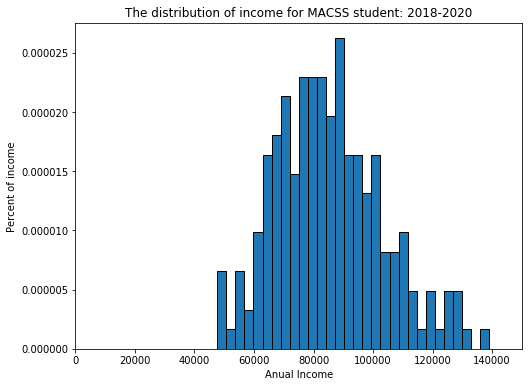

In [2]:
#a) A histogram of income
income = np.loadtxt("./data/incomes.txt")
num_bins = 30
plt.figure(figsize = (8,6))
plt.title("The distribution of income for MACSS student: 2018-2020")
plt.xlabel("Anual Income")
plt.ylabel("Percent of income")
plt.xlim([0, 150000]) 
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

In [3]:
#b)
# Define function that generates values of a log normal pdf
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

def data_moments(xvals):
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data

def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, var_model

def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [4]:
#Perform GMM method with identity matrix as weighting matrix
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, 0.0, 150000.0, W_hat)
results_1 = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results_1.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.333599653389053  sig_GMM1= 0.21325528936239227


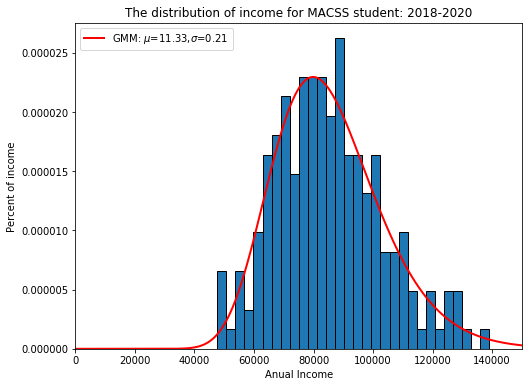

In [5]:
#Plot my estimated lognormal PDF on the orginal plot
num_bins = 30
plt.figure(figsize = (8,6))
plt.title("The distribution of income for MACSS student: 2018-2020")
plt.xlabel("Anual Income")
plt.ylabel("Percent of income")
plt.xlim([0, 150000]) 
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

dist_income = np.linspace(1, 150000, 2000)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1, 0, 150000),
         linewidth=2, color='r', label='GMM: $\mu$=11.33,$\sigma$=0.21')
plt.legend(loc='upper left')

In [6]:
#The value of GMM criterion function
print("The value of GMM criterion function:", results_1.fun)

The value of GMM criterion function: [[3.38120746e-15]]


In [7]:
#Compare data moments and model moments
mean_data, var_data = data_moments(income)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1, 0, 150000)
err_1 = err_vec(income, mu_GMM1, sig_GMM1, 0, 150000, False).reshape(2,)
print("mean from data:", mean_data, "variance from data:", var_data)
print("mean from model:", mean_model, "variance from model:", var_model)
print("error vector:", err_1)

mean from data: 85276.82360625811 variance from data: 323731572.2295289
mean from model: 85276.82730374348 variance from model: 323731559.68628794
error vector: [ 4.33586198e-08 -3.87458068e-08]


In [8]:
#c) Perform two-step GMM estimate
def get_Err_mat2(income, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(income)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = income - mean_model
        Err_mat[1, :] = ((mean_data - income) ** 2) - var_model
    else:
        Err_mat[0, :] = (income - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - income) ** 2) - var_model) / var_model
    
    return Err_mat

In [9]:
Err_mat = get_Err_mat2(income, mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / income.shape[0]) * (Err_mat @ Err_mat.T)
print("The variance covariance matrix:")
print(VCV2)
W_hat2 = lin.inv(VCV2)
print("Optimal weighting matrix:")
print(W_hat2)

The variance covariance matrix:
[[0.0445167  0.09358616]
 [0.09358616 1.94756676]]
Optimal weighting matrix:
[[24.98774377 -1.20073264]
 [-1.20073264  0.57115986]]


In [11]:
#Perform the two step GMM estmation
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
gmm_args = (income, 0.0, 150000.0, W_hat2)
results_2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results_2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.333599601683714  sig_GMM2= 0.21325529904012167


In [12]:
#The value of GMM criterion function
print("The value of GMM criterion function:", results_2.fun)

The value of GMM criterion function: [[9.74415555e-16]]


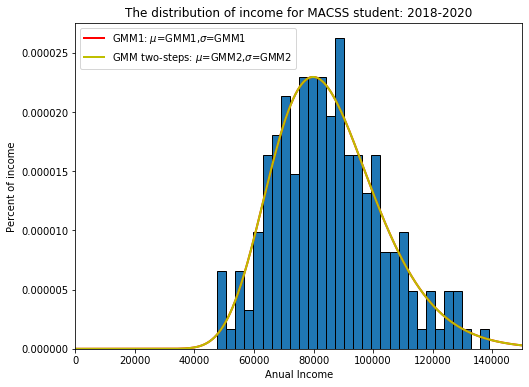

In [13]:
#Plot my estimated PDF along with the estimates in b)
num_bins = 30
plt.figure(figsize = (8,6))
plt.title("The distribution of income for MACSS student: 2018-2020")
plt.xlabel("Anual Income")
plt.ylabel("Percent of income")
plt.xlim([0, 150000]) 
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

dist_income = np.linspace(1, 150000, 2000)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1, 0, 150000),
         linewidth=2, color='r', label='GMM1: $\mu$=GMM1,$\sigma$=GMM1')
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM2, sig_GMM2, 0, 150000),
         linewidth=2, color='y', label='GMM two-steps: $\mu$=GMM2,$\sigma$=GMM2')
plt.legend(loc='upper left')

In [14]:
#Compare data moments and model moments
mean_data, var_data = data_moments(income)
mean_model_2, var_model_2 = model_moments(mu_GMM2, sig_GMM2, 0, 150000)
err_2 = err_vec(income, mu_GMM2, sig_GMM2, 0, 150000, False).reshape(2,)
print("mean from data:", mean_data, "variance from data:", var_data)
print("mean from model:", mean_model_2, "variance from model:", var_model_2)
print("error vector:", err_2)

mean from data: 85276.82360625811 variance from data: 323731572.2295289
mean from model: 85276.8231281229 variance from model: 323731561.39808923
error vector: [-5.60686008e-09 -3.34580887e-08]


In [18]:
#d) Estimate using 3 moments
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [23]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat1_3 = np.eye(3)
gmm_args = (income, 0.0, 150000.0, W_hat1_3)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM3, sig_GMM3 = results_3.x
print('mu_GMM_3=', mu_GMM3, ' sig_GMM_3=', sig_GMM3)

mu_GMM_3= 11.336705110696542  sig_GMM_3= 0.21151357584031807


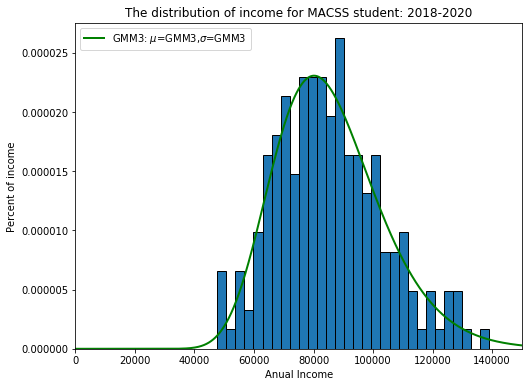

In [24]:
#Plot my estimated PDF along with the estimates in a)
num_bins = 30
plt.figure(figsize = (8,6))
plt.title("The distribution of income for MACSS student: 2018-2020")
plt.xlabel("Anual Income")
plt.ylabel("Percent of income")
plt.xlim([0, 150000]) 
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

dist_income = np.linspace(1, 150000, 2000)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM3, sig_GMM3, 0, 150000),
         linewidth=2, color='g', label='GMM3: $\mu$=GMM3,$\sigma$=GMM3')
plt.legend(loc='upper left')

In [25]:
#The value of GMM criterion function
print("The value of GMM criterion function:", results_3.fun)

The value of GMM criterion function: [[4.29637851e-13]]


In [29]:
#Compare data moments and estimated moments:
mom_data1, mom_data2, mom_data3 = data_moments3(income)
mom_model1, mom_model2, mom_model3 = model_moments3(mu_GMM3, sig_GMM3, 0.0, 150000.0)
#Construct a dataframe with three columns to compare
mom3_df = pd.DataFrame(columns = ['Moment', 'Data moment', 'Model moment'])
mom3_df = mom3_df.append({'Moment':'<75,000', 'Data moment':mom_data1, 'Model moment':mom_model1}, ignore_index=True)
mom3_df = mom3_df.append({'Moment':'75,000-100,000', 'Data moment':mom_data2, 'Model moment':mom_model2}, ignore_index=True)
mom3_df = mom3_df.append({'Moment':'>100,000', 'Data moment':mom_data3, 'Model moment':mom_model3}, ignore_index=True)
mom3_df

,Moment,Data moment,Model moment
0,"<75,000",0.3,0.3
1,"75,000-100,000",0.5,0.5
2,">100,000",0.2,0.2


In [30]:
err_3 = err_vec3(income, mu_GMM3, sig_GMM3, 0.0, 150000.0, False).reshape(3,)
print("error vector:", err_3)

error vector: [ 5.68178102e-07 -2.63658481e-07 -1.93120949e-07]


In [35]:
#e) Perform two-step GMM estimate using three moments
def Jac_err3(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    Jac_err = np.zeros((3, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = \
        ((err_vec3(xvals, mu + h_mu, sigma, cut_lb, cut_ub, simple) -
          err_vec3(xvals, mu - h_mu, sigma, cut_lb, cut_ub, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec3(xvals, mu, sigma + h_sig, cut_lb, cut_ub, simple) -
          err_vec3(xvals, mu, sigma - h_sig, cut_lb, cut_ub, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err

def get_Err_mat3(income, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(income)
    Err_mat = np.zeros((R, N))
    inc_1_mod, inc_2_mod, inc_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        inc_in_grp1 = income < 75000
        Err_mat[0, :] = inc_in_grp1 - inc_1_mod
        inc_in_grp2 = (income >= 75000) & (income < 100000)
        Err_mat[1, :] = inc_in_grp2 - inc_2_mod
        inc_in_grp3 = income >= 100000
        Err_mat[2, :] = inc_in_grp3 - inc_3_mod
    else:
        inc_in_grp1 = income < 75000
        Err_mat[0, :] = (inc_in_grp1 - inc_1_mod) / inc_1_mod
        inc_in_grp2 = (income >= 75000) & (income < 100000)
        Err_mat[1, :] = (inc_in_grp2 - inc_2_mod) / inc_2_mod
        inc_in_grp3 = income >= 100000
        Err_mat[2, :] = (inc_in_grp3 - inc_3_mod) / inc_3_mod
    
    return Err_mat

In [38]:
Err_mat3 = get_Err_mat3(income, mu_GMM3, sig_GMM3, 0.0, 150000.0, False)
VCV2_4 = (1 / income.shape[0]) * (Err_mat3 @ Err_mat3.T)
print("The variance covariance matrix:")
print(VCV2_4)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_4 = lin.pinv(VCV2_4)
print("Optimal weighting matrix:")
print(W_hat2_4)

The variance covariance matrix:
[[ 2.33333068 -0.9999997  -0.99999962]
 [-0.9999997   1.00000053 -1.00000046]
 [-0.99999962 -1.00000046  4.00000154]]
Optimal weighting matrix:
[[ 0.25761782 -0.14958464 -0.01246545]
 [-0.14958464  0.11911371 -0.07340713]
 [-0.01246545 -0.07340713  0.20221599]]


In [44]:
mu_init = 11
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
gmm_args = (income, 0.0, 150000.0, W_hat2_4)
results_4 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-2, None)))
mu_GMM4, sig_GMM4 = results_4.x
print('mu_GMM_4=', mu_GMM4, ' sig_GMM_4=', sig_GMM4)

mu_GMM_4= 11.336705179801386  sig_GMM_4= 0.2115135169406789


In [45]:
#The value of GMM criterion function
print("The value of GMM criterion function:", results_4.fun)

The value of GMM criterion function: [[4.72917126e-16]]


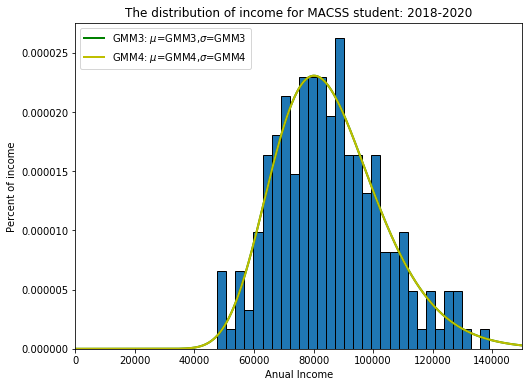

In [46]:
#Plot my estimated PDF along with the estimates in a)
num_bins = 30
plt.figure(figsize = (8,6))
plt.title("The distribution of income for MACSS student: 2018-2020")
plt.xlabel("Anual Income")
plt.ylabel("Percent of income")
plt.xlim([0, 150000]) 
count, bins, ignored = plt.hist(income, num_bins, density=True, edgecolor='k')

dist_income = np.linspace(1, 150000, 2000)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM3, sig_GMM3, 0, 150000),
         linewidth=2, color='g', label='GMM3: $\mu$=GMM3,$\sigma$=GMM3')
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM3, sig_GMM3, 0, 150000),
         linewidth=2, color='y', label='GMM4: $\mu$=GMM4,$\sigma$=GMM4')
plt.legend(loc='upper left')

In [47]:
#Compare data moments and estimated moments:
mom_data1, mom_data2, mom_data3 = data_moments3(income)
mom_model1, mom_model2, mom_model3 = model_moments3(mu_GMM4, sig_GMM4, 0.0, 150000.0)
#Construct a dataframe with three columns to compare
mom3_df = pd.DataFrame(columns = ['Moment', 'Data moment', 'Model moment'])
mom3_df = mom3_df.append({'Moment':'<75,000', 'Data moment':mom_data1, 'Model moment':mom_model1}, ignore_index=True)
mom3_df = mom3_df.append({'Moment':'75,000-100,000', 'Data moment':mom_data2, 'Model moment':mom_model2}, ignore_index=True)
mom3_df = mom3_df.append({'Moment':'>100,000', 'Data moment':mom_data3, 'Model moment':mom_model3}, ignore_index=True)
mom3_df

,Moment,Data moment,Model moment
0,"<75,000",0.3,0.3
1,"75,000-100,000",0.5,0.5
2,">100,000",0.2,0.2


In [48]:
#f) Compare four GMM estimates
mu = [mu_GMM1, mu_GMM2, mu_GMM3, mu_GMM4]
sig = [sig_GMM1, sig_GMM2, sig_GMM3, sig_GMM4]
funcv = [results_1.fun, results_2.fun, results_3.fun, results_4.fun]
pd.DataFrame({"mu":mu,"sigma":sig,"Value of GMM func":funcv}
            ,index=['2 moments with Identity Matrix','2 moments with Weighted Matrix',
                   '3 moments with Identity Matrix','3 moments with Weighted Matrix']) \
             .astype(float)

,mu,sigma,Value of GMM func
2 moments with Identity Matrix,11.333600,0.213255,3.381207e-15
2 moments with Weighted Matrix,11.333600,0.213255,9.744156e-16
3 moments with Identity Matrix,11.336705,0.211514,4.296379e-13
3 moments with Weighted Matrix,11.336705,0.211514,4.729171e-16


Generalized from the above, 3 moments GMM with weightes matrix has the smallest function value, hence is the best estimate in this case. 

### Exercise 2. 

In [49]:
#a) Estimate the model using GMM
sick_df = pd.read_csv("./data/sick.txt")
sick_df

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90
...,...,...,...,...
195,0.53,30.56,0.74,41.76
196,0.86,33.97,1.40,39.10
197,1.39,44.00,2.45,40.95
198,0.72,22.30,1.03,23.14


In [50]:
#Error function of moments
def err_vec(y, x1, x2, x3, b0, b1, b2, b3, simple):
    yhat = b0 + b1*x1 + b2*x2 + b3*x3
    if simple:
        return y-yhat
    else:
        return (y-yhat)/yhat
    
def criterion(params, *args):
    b0, b1, b2, b3 = params
    y, x1, x2, x3, W = args
    err = err_vec(y, x1, x2, x3, b0, b1, b2, b3, True)
    crit_val = err.T @ W @ err
    return crit_val

In [51]:
b0_init, b1_init, b2_init, b3_init = 1, 0, 0, 0
params_init = np.array([b0_init, b1_init, b2_init, b3_init])
W_hat = np.eye(200)
gmm_args = (sick_df['sick'], sick_df['age'], sick_df['children'], sick_df['avgtemp_winter'], W_hat)
res = opt.minimize(criterion, params_init, args=(gmm_args),tol=1e-14, method='L-BFGS-B')
b0, b1, b2, b3 = res.x
val_crit = res.fun
print("Estimate of b0:",b0)
print("Estimate of b1:",b1)
print("Estimate of b2:",b2)
print("Estimate of b3:",b3)
print('Value of GMM criterion function:',val_crit)

Estimate of b0: 0.2516448640150513
Estimate of b1: 0.012933471011867557
Estimate of b2: 0.40050098412750457
Estimate of b3: -0.009991709739756627
Value of GMM criterion function: 0.001821289806039237
